# 3D image classification from skull scans

**Author:** [Hasib Zunair](https://twitter.com/hasibzunair)<br>
**Date created:** 2020/09/23<br>
**Last modified:** 2020/09/23<br>
**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [1]:
def download_scans():
    
    # Make a directory to store the data.
    os.makedirs("TrainingData")    
                
    # Training Set
    url = "https://dl.dropboxusercontent.com/s/2v09h0vt0k3x9l3/training_set.zip?dl=0"
    filename = os.path.join(os.getcwd(), "training_set.zip")
    keras.utils.get_file(filename, url)
                
    # Unzip data in the newly created directory.
    with zipfile.ZipFile("training_set.zip", "r") as z_fp:
        z_fp.extractall("./TrainingData/")
    
    # Testing Set
    url = "https://dl.dropboxusercontent.com/s/me3yh4azub7jbpn/test_set_for_participants.zip?dl=0"
    filename = os.path.join(os.getcwd(), "test_set_for_participants.zip")
    keras.utils.get_file(filename, url)
  
    # Unzip data in the newly created directory.
    with zipfile.ZipFile("test_set_for_participants.zip", "r") as z_fp:
        z_fp.extractall("./TrainingData/")

    # 10 additional cases
    url = "https://dl.dropboxusercontent.com/s/7ijvewjw4lnjyjv/additional_test_set_for_participants.zip?dl=0"
    filename = os.path.join(os.getcwd(), "additional_test_set_for_participants.zip")
    keras.utils.get_file(filename, url)
   
    # Unzip data in the newly created directory.
    with zipfile.ZipFile("additional_test_set_for_participants.zip", "r") as z_fp:
        z_fp.extractall("./TrainingData/")
    

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [2]:
def read_nrrd_header(filepath):
    """Read header"""
    hd=nrrd.read_header(filepath)
    return hd

def read_nrrd_file(filepath):
    """Read and load volume"""
    data,hd=nrrd.read(filepath)
    # Get raw data
    #scan = scan.get_fdata()
    #data,hd=nrrd.read('C:/Users/jonathan.keaveney.ICONXSOLUTIONS/Documents/College/Modules/ED5005/Data/training_set/training_set/defective_skull/000.nrrd')
    return data


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def resizing(label):
    a,b,c=label.shape
    resized_data = ndimage.zoom(label,(128/a,128/b,64/c),order=2, mode='constant')  
    return resized_data

def process_skull_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nrrd_file(path)
    # Normalize
    # volume = normalize(volume)
    # Resize width, height and depth
    #volume = resize_volume(volume)
    volume = resizing(volume)
    return volume


In [3]:
def load_training_data():
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    normal_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/training_set/complete_skull", x)
        for x in os.listdir("TrainingData/training_set/complete_skull")
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    abnormal_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/training_set/defective_skull", x)
        for x in os.listdir("TrainingData/training_set/defective_skull")
    ]

    return normal_scan_paths, abnormal_scan_paths

In [4]:
def load_test_data():
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    test_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/test_set_for_participants", x)
        for x in os.listdir("TrainingData/test_set_for_participants")
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    additional_test_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/additional_test_set_for_participants", x)
        for x in os.listdir("TrainingData/additional_test_set_for_participants")
    ]
    
    return test_scan_paths, additional_test_scan_paths

Let's read the paths of the CT scans from the class directories.

## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [5]:
# read file headers
#[print(path + ': ' + str(read_nrrd_header(path)['sizes'])) for path in abnormal_scan_paths]
#[read_nrrd_header(path) for path in normal_scan_paths]

In [6]:
def build_dataset_and_train_test_split(train_size, normal_scan_paths, abnormal_scan_paths):
    normal_scans = np.array([process_skull_scan(path) for path in normal_scan_paths])
    abnormal_scans = np.array([process_skull_scan(path) for path in abnormal_scan_paths])
    
    # split
    x_train = abnormal_scans[:train_size]
    y_train = normal_scans[:train_size].astype("float32")
    x_val = abnormal_scans[train_size:]
    y_val = normal_scans[train_size:].astype("float32")
    
    return x_train, y_train, x_val, y_val


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [7]:
def define_data_loaders(batch_size):
    
    @tf.function
    def rotate(volume, label):
        """Rotate the volume by a few degrees"""

        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        
        def scipy_rotate_volumn(volume):
            # define some rotation angles
            
            # rotate volume
            volume = ndimage.rotate(volume, angle, reshape=False)
            volume[volume < 0] = 0
            volume[volume > 1] = 1
            return volume
        
        def scipy_rotate_label(label):
            # define some rotation angles
            
            # rotate volume
            label = ndimage.rotate(label, angle, reshape=False)
            label[label < 0] = 0
            label[label > 1] = 1
            return label

        augmented_volume = tf.numpy_function(scipy_rotate_volumn, [volume], tf.int32)
        augmented_label = tf.numpy_function(scipy_rotate_label, [label], tf.int32)
        
        return augmented_volume, augmented_label


    def train_preprocessing(volume, label):
        """Process training data by rotating and adding a channel."""
        # Rotate volume
        #volume, label = rotate(volume, label)
        volume = tf.expand_dims(volume, axis=3)
        label = tf.expand_dims(label, axis=3)
        return volume, label


    def validation_preprocessing(volume, label):
        """Process validation data by only adding a channel."""
        volume = tf.expand_dims(volume, axis=3)
        label = tf.expand_dims(label, axis=3)
        return volume, label
    
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    
    return train_dataset, validation_dataset

Visualize an augmented CT scan.

In [8]:
def visualize_augmented_ct_scan(data):
    images, labels = list(data)[0]
    images = images.numpy()
    image = images[0]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[:, :,30]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, :,40]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, :,50]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, :,60]), cmap="gray")


Since a CT scan has many slices, let's visualize a montage of the slices.

In [9]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


## Loss Functions

In [135]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)
    
def dice_coeff(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    #y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    #print(numerator)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / denominator

In [136]:
# def DiceLoss(targets, inputs, smooth=1e-6):
#     targets = tf.cast(targets, tf.float32)
#     inputs = tf.cast(inputs, tf.float32)
    
#     #flatten label and prediction tensors
#     inputs = tf.keras.backend.flatten(inputs)
#     targets = tf.keras.backend.flatten(targets)
#     prod = tf.keras.backend.dot(targets, inputs)
#     intersection = tf.keras.backend.sum(prod)
#     dice = (2*intersection + smooth) / (tf.keras.backend.sum(targets) + tf.keras.backend.sum(inputs) + smooth)
#     return 1 - dice

def DiceLoss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - score


In [137]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    loss = (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)
    return 1-loss


In [142]:
# Test
y_true = np.array([[0,0,1,0],[0,0,1,0],[0,0,1.,0.]])
#y_true = np.array([[0,0,0,0.],[0,0,0,0],[0,0,0,0.]])
y_pred = np.array([[0,0,0.9,1],[0,0,0.8,0],[0,0,0.9,1.]])
#y_pred = np.array([[1,1,0.9,1],[1,1,1.1,1],[1,1,1.1,1.]])

r = dice_coeff(y_true,y_pred).numpy()
print('dice_coef_loss',r)
r = DiceLoss(y_true,y_pred).numpy()
print('dice_coef_loss',r)
r = dice_coef(y_true,y_pred).numpy()
print('dice_coef_loss',r)

dice_coef_loss 0.68421054
dice_coef_loss 0.3157894321329694
dice_coef_loss [0.3594306  0.02439028 0.3594306 ]


## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [14]:
def get_unet(width=128, height=128, depth=64, filtersValue=16):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    
    conv1 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv1)
    conv2 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv2)
    conv3 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv3)
    conv4 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPool3D(pool_size=(2, 2, 2))(drop4)

    conv5 = layers.Conv3D(filtersValue*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = layers.Conv3D(filtersValue*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv3D(filtersValue*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 4)
    conv6 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = layers.Conv3D(filtersValue*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 4)
    conv7 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = layers.Conv3D(filtersValue*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 4)
    conv8 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = layers.Conv3D(filtersValue, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 4)
    conv9 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = layers.Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    out = layers.Conv3D(1, 3, activation = 'sigmoid', padding = 'same')(conv9)

    model = keras.Model(inputs = inputs, outputs = out, name="3dcnn")
    #model.compile(optimizer = "sgd", loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(inputs = inputs, outputs = conv10)


## Train model

In [12]:
#!pip install nibabel
#!pip install matplotlib
#!pip install matplotlib

#import nibabel as nib
import nrrd
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage


#download_scans()
normal_scan_paths, abnormal_scan_paths = load_training_data()
print("CT scans with normal skull: " + str(len(normal_scan_paths)))
print("CT scans with defective skull: " + str(len(abnormal_scan_paths)))

# test_scan_paths, additional_test_scan_paths = load_test_data()
# print("CT scans with normal skull: " + str(len(normal_scan_paths)))
# print("CT scans with defective skull: " + str(len(abnormal_scan_paths)))

x_train, y_train, x_val, y_val = build_dataset_and_train_test_split(70, normal_scan_paths, abnormal_scan_paths)
    
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

train_dataset, validation_dataset = define_data_loaders(2)
    
# visualize_augmented_ct_scan(train_dataset.take(1)):
# # Visualize montage of slices.
# # 4 rows and 10 columns for 100 slices of the CT scan.
# plot_slices(6, 10, 128, 128, x_train[0][:, :, :60])
# plot_slices(6, 10, 128, 128, y_train[0][:, :, :60])

CT scans with normal skull: 100
CT scans with defective skull: 100
Number of samples in train and validation are 70 and 30.


In [29]:
# Build model.
model = get_unet(width=128, height=128, depth=64, filtersValue=8)
model.summary(line_length=150)

# Defin data loaders
#train_dataset, validation_dataset = define_data_loaders(4)

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    #loss="binary_crossentropy",
    loss=dice_loss,
    #loss="sparse_categorical_crossentropy",
    #loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_implant_generation003.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 8
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Model: "3dcnn"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_4 (InputLayer)                             [(None, 128, 128, 64, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_69 (Conv3D)                               (None, 128, 128, 64, 8)          224               input_4[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_70 (Conv3D)                               (None, 128, 128, 64, 8)       

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

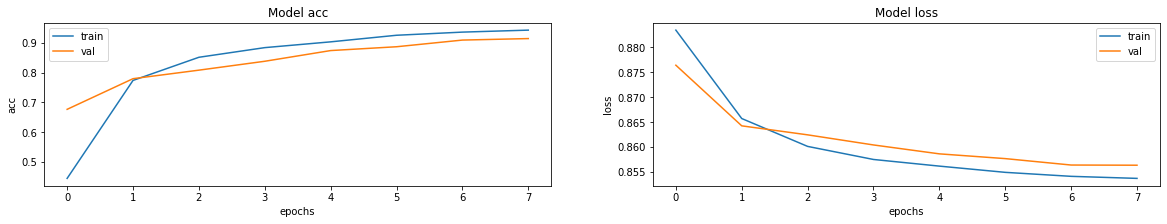

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single CT scan

In [155]:
for i in np.linspace(0.9999,1,20):
    print(i, end=', ')

0.9999, 0.9999052631578947, 0.9999105263157895, 0.9999157894736842, 0.9999210526315789, 0.9999263157894737, 0.9999315789473684, 0.9999368421052631, 0.9999421052631579, 0.9999473684210526, 0.9999526315789474, 0.9999578947368422, 0.9999631578947369, 0.9999684210526316, 0.9999736842105263, 0.9999789473684211, 0.9999842105263158, 0.9999894736842105, 0.9999947368421053, 1.0, 

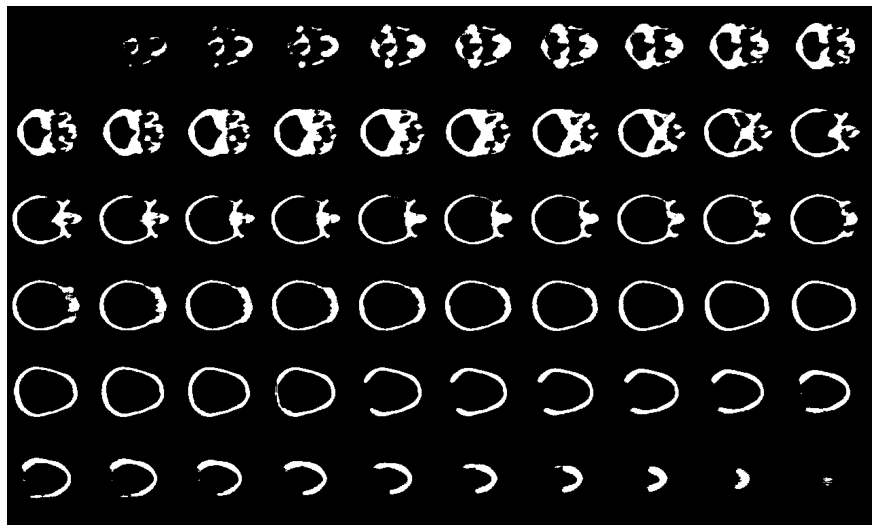

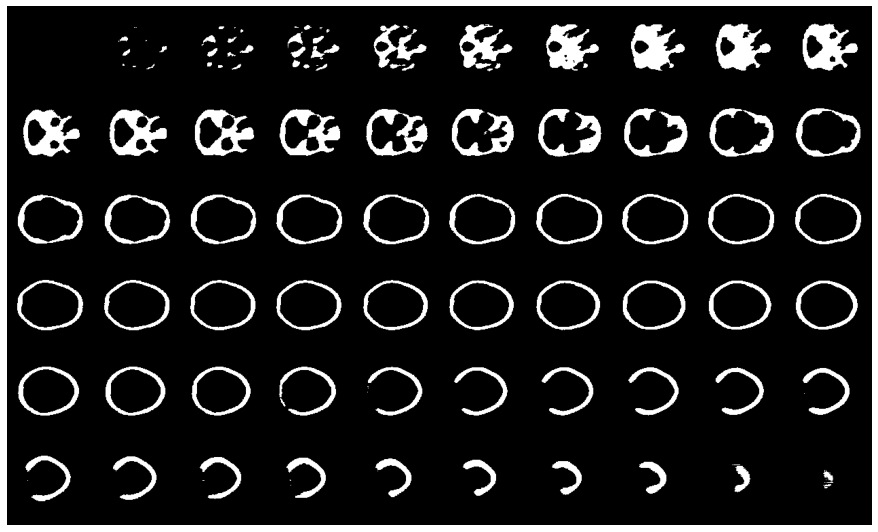

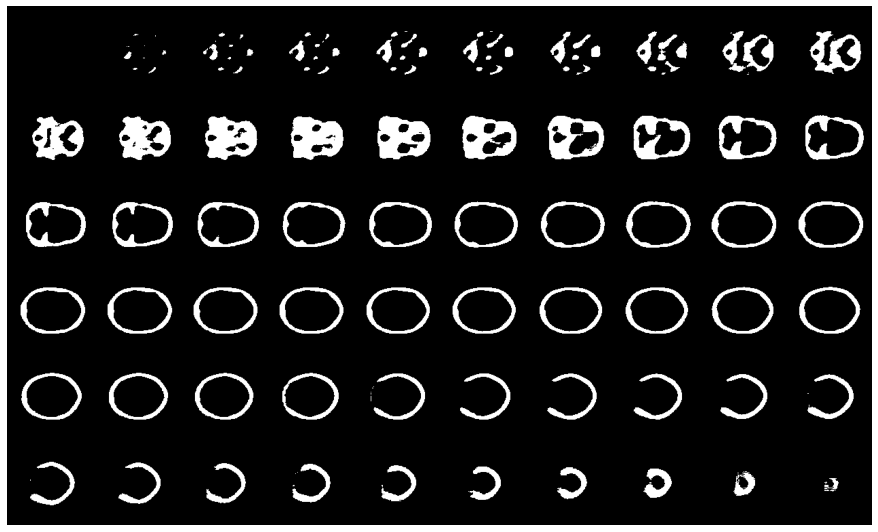

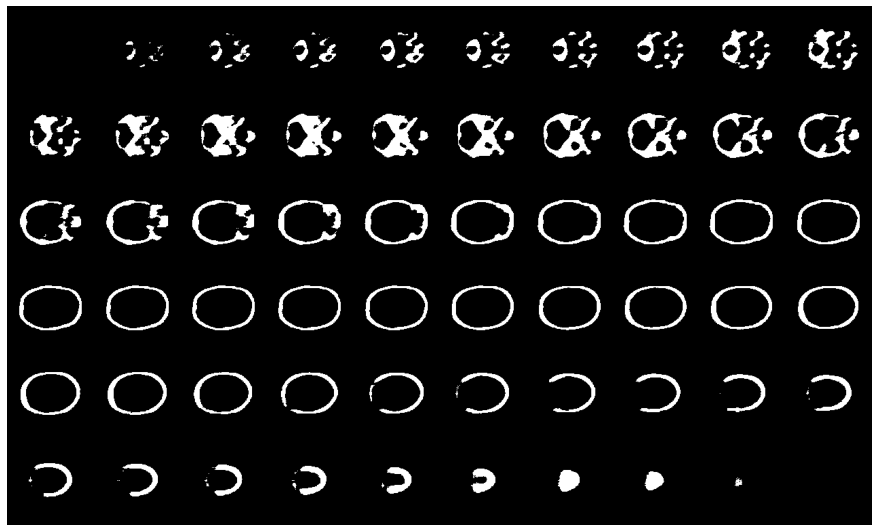

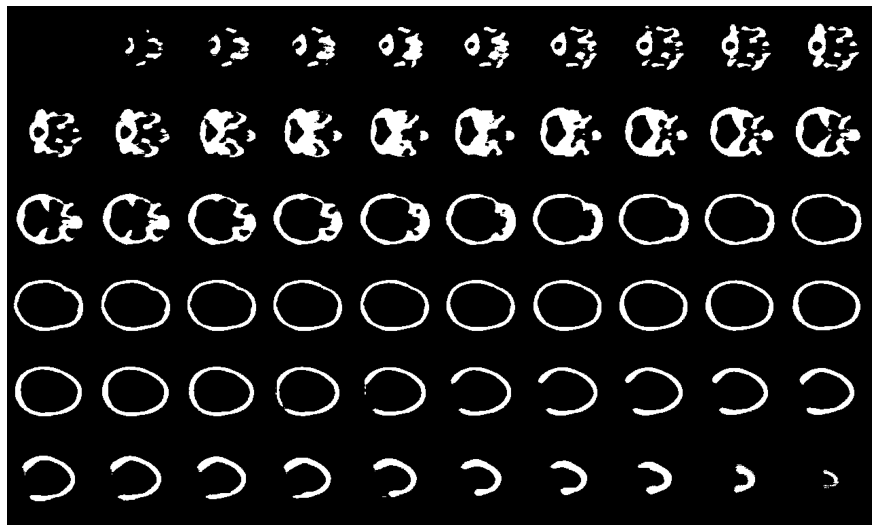

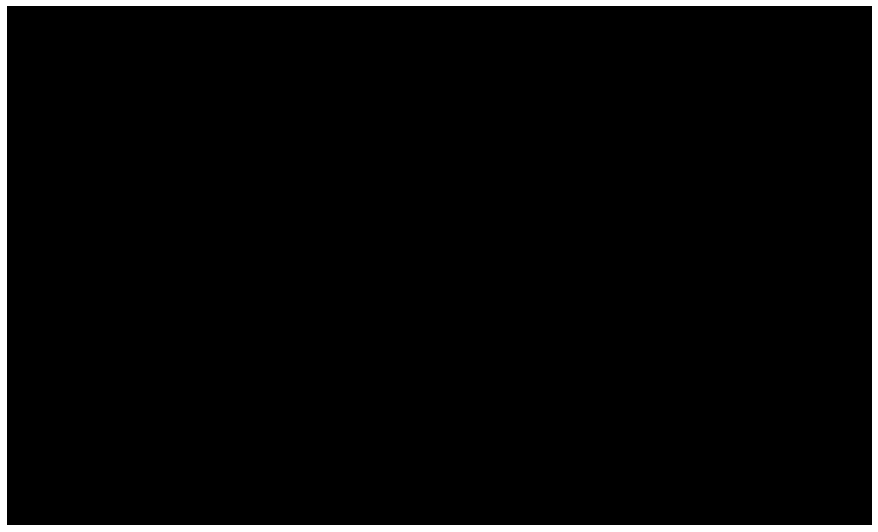

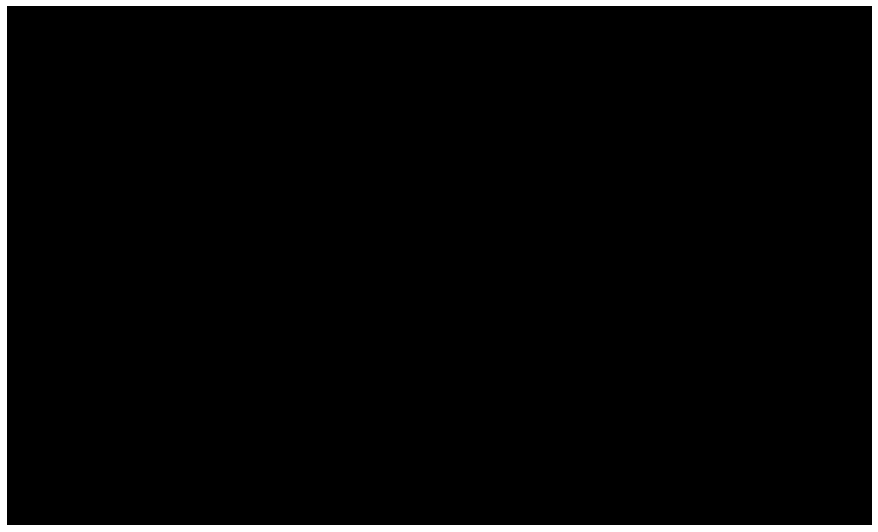

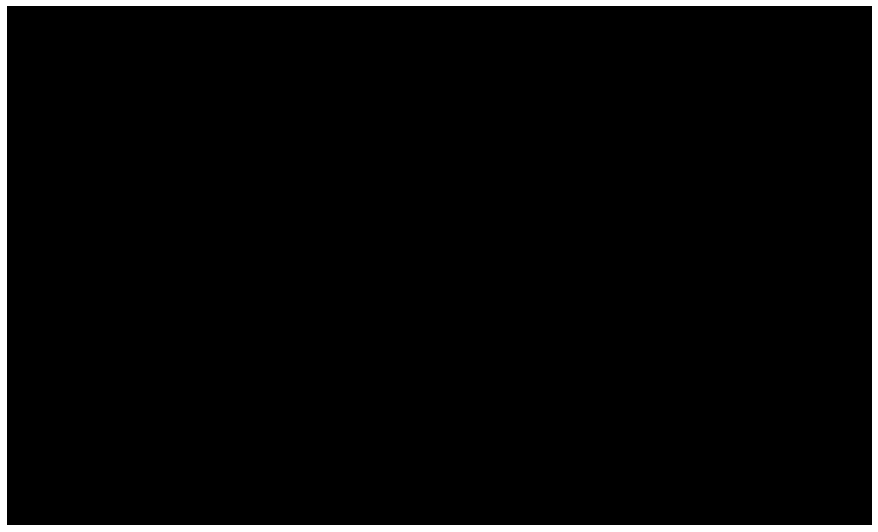

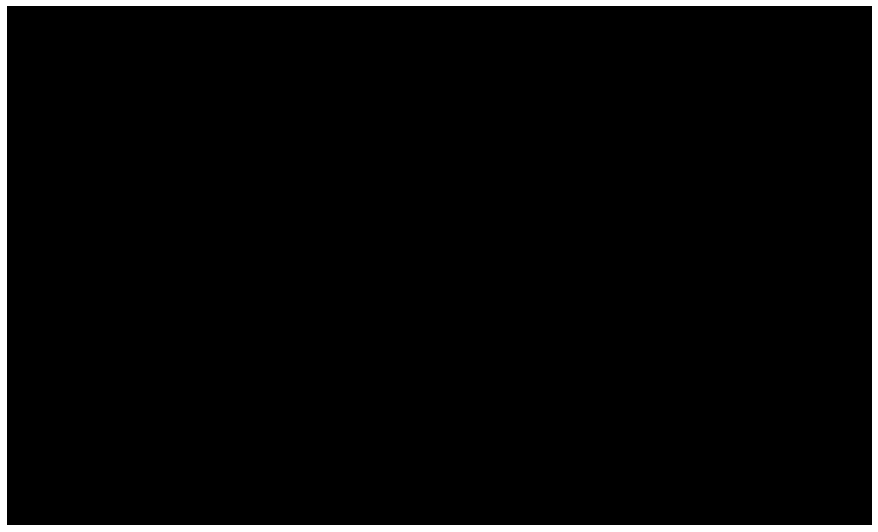

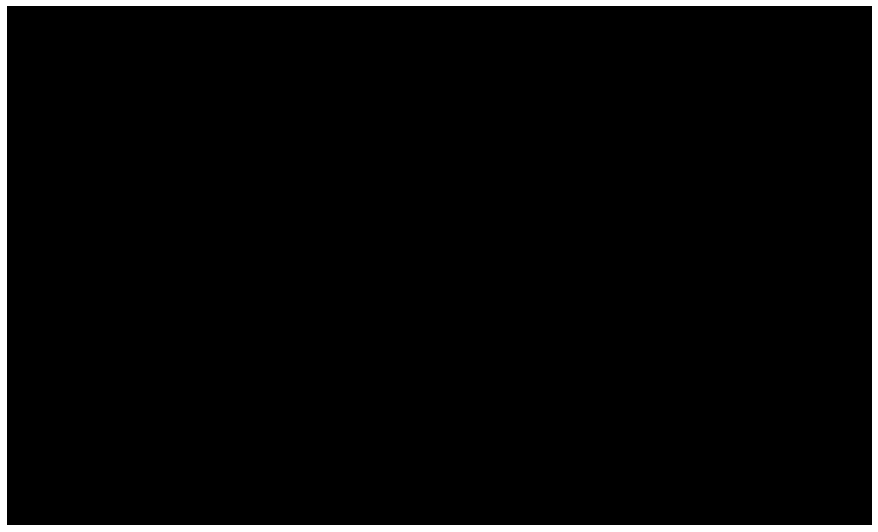

In [161]:
#!pip install sklearn
# model.load_weights("3d_implant_generation003.h5")
avg_dice_loss_scores = []
predictions = []

for i in range(y_val.shape[0]):
    prediction= model.predict(np.expand_dims(x_val[i], axis=0))[0]
    predictions.append(prediction)
    
for ls in np.linspace(0.9999,1,2):
    dice_loss_scores = []
    #for i in range(y_val.shape[0]):
    for i in range(5):
        prediction = predictions[i]
        
#         print(prediction[:,:,:,0].shape)
#         print(y_val[i].shape) 
        #dice_loss_scores.append(DiceLoss(np.where(prediction[:,:,:,0]>ls,1,0),y_val[i].astype('float32')).numpy())
        #dice_loss_scores.append(dice_coef(np.where(prediction[:,:,:,0]>ls,1,0),y_val[i].astype('float32')).numpy())
        plot_slices(6, 10, 128, 128,np.where(prediction[:,:,:,0]>ls,1,0)[:, :, :60])
        dice_loss_scores.append(dice_coeff(np.where(prediction[:,:,:,0]>ls,1,0),y_val[i].astype('float32')).numpy())
        

    avg_dice_loss_scores.append(sum(dice_loss_scores) / len(dice_loss_scores))
    


# import scipy
# from sklearn.metrics import accuracy_score

# def thr_to_accuracy(thr, y_val, predictions):
#    return -accuracy_score(y_val, np.array(predictions>thr, dtype=np.int))

# i = 0
# prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
# best_thr = scipy.optimize.fmin(thr_to_accuracy, args=(y_val[i].astype('float32'), prediction.astype('float32')), x0=0.5)
# print(best_thr) 0.7988993108272553, 0.8067788561185201, 0.8263887107372284, 0.8588930189609527

# 0.61966314315795, 0.6614419718583425, 0.6997271835803985, 0.7296699345111847

In [154]:
print(avg_dice_loss_scores)

[0.7233208020528158, 0.7239614228407542, 0.7246048390865326, 0.725232324997584, 0.7259465118249258, 0.7266748627026876, 0.727366421620051, 0.7281469603379568, 0.7289167582988739, 0.7296699345111847, 0.7305085023244222, 0.7313171883424123, 0.7320837418238322, 0.7327641189098358, 0.7330667773882548, 0.733043909072876, 0.7321031630039215, 0.7284821629524231, 0.7151473879814148, 0.0]


In [31]:
model.load_weights("3d_implant_generation003.h5")

dice_loss_scores = []
for i in range(y_val.shape[0]):
    prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
    dice_loss_scores.append(dice_loss(prediction[:,:,:,0],y_val[i].astype('float32')).numpy())

print(sum(dice_loss_scores) / len(dice_loss_scores))


0.7409667948881785


dsc = 0.8710173527399699 using loss="categorical_crossentropy" for filtersValue=4 (300K paramaters) - loss is flat & output doesn't look like skull

dsc = 0.6751154164473215 using dice_loss for filtersValue=4 (300K paramaters) - some shape but poor mimic of skull

dsc = 0.7409667948881785 for filtersValue=8 (1.4 million paramaters)

dsc = X for filtersValue=16 (5.6 million paramaters)

dsc = X for filtersValue=16 (5.6 million paramaters) with random rotations in training

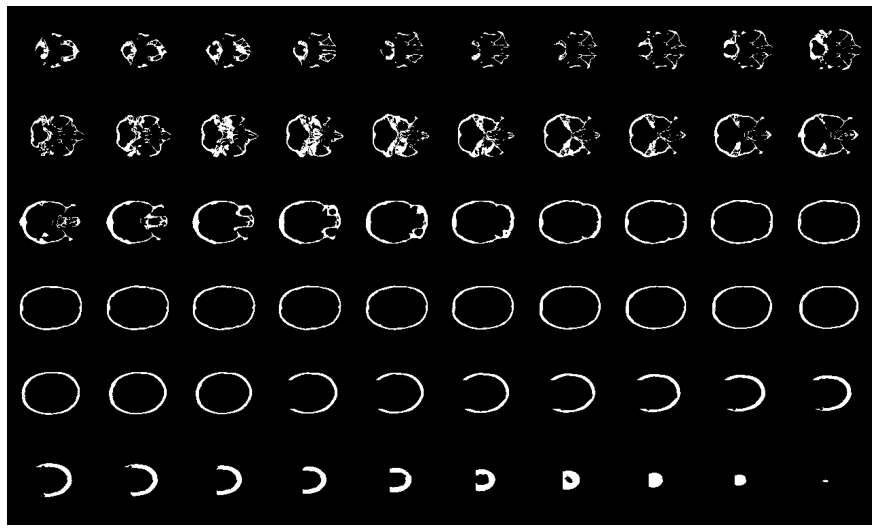

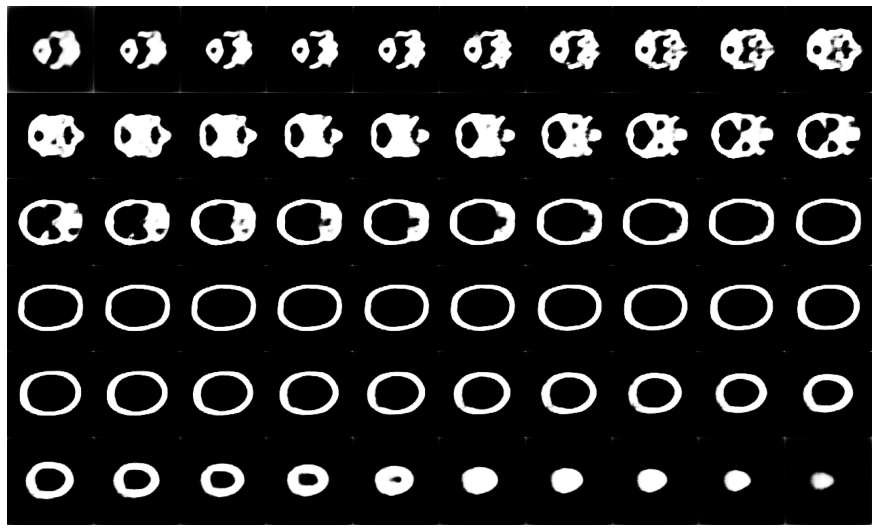

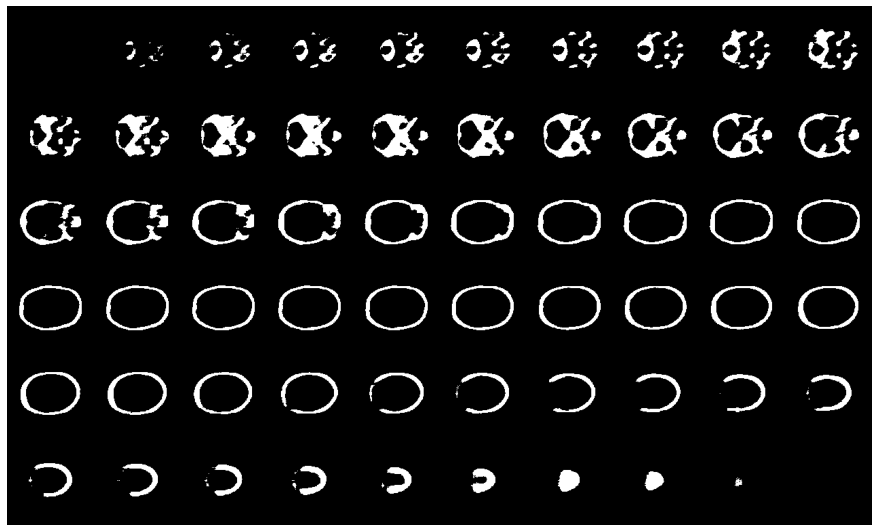

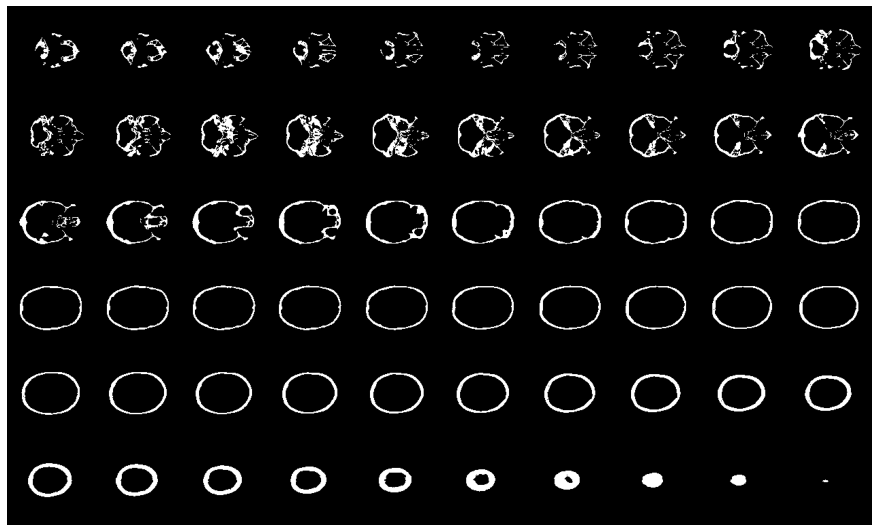

In [160]:
plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
plot_slices(6, 10, 128, 128,p[:, :, :60])
plot_slices(6, 10, 128, 128,np.where(p[:,:,:,0]>0.9999,1,0)[:, :, :60])
plot_slices(6, 10, 128, 128,y_val[3][:, :, :60])

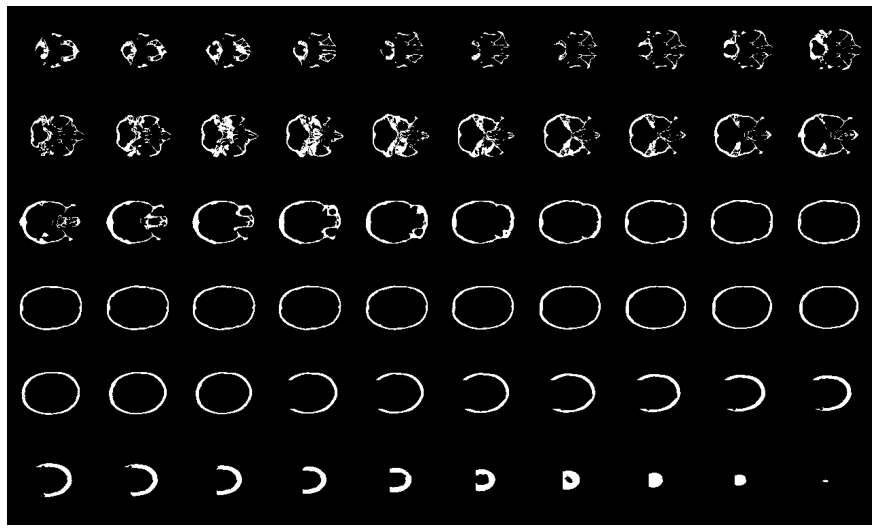

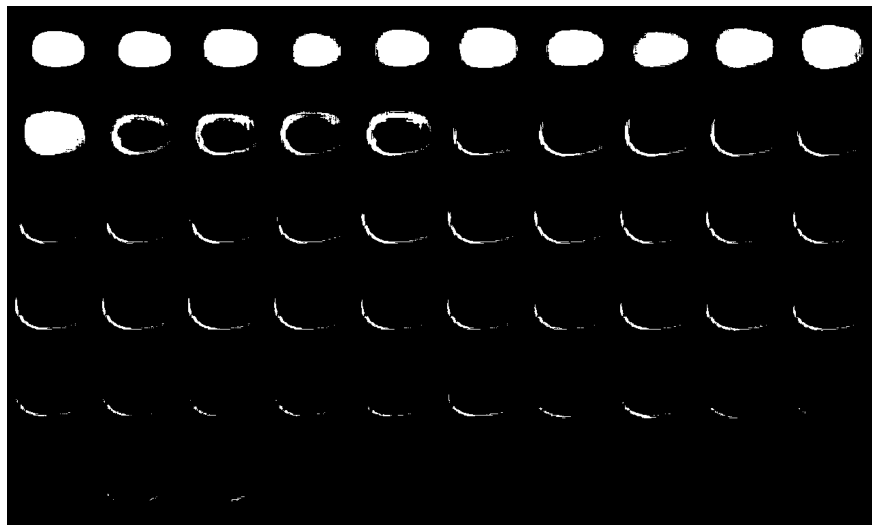

In [28]:
plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
plot_slices(6, 10, 128, 128,np.where(p>0.999999,1,0)[:, :, :60])

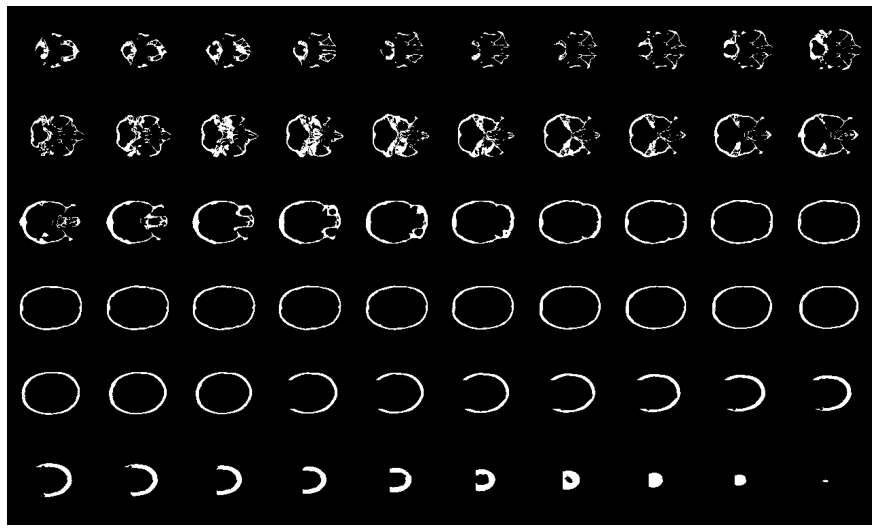

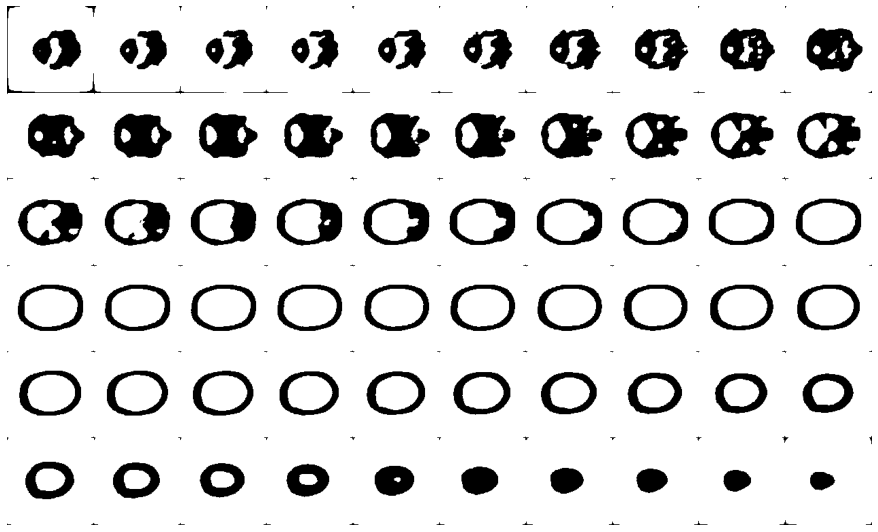

In [63]:
plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
plot_slices(6, 10, 128, 128,p[:, :, :60])
plot_slices(6, 10, 128, 128,np.where(p>0.1,1,0)[:, :, :60])

In [37]:
model.evaluate(np.expand_dims(abnormal_scans[3], axis=0), np.expand_dims(normal_scans[3], axis=0))

1/1 [==============================] - 0s 390ms/step - loss: 0.8628 - acc: 0.9817


[0.8627868890762329, 0.9817333221435547]

In [27]:
p.shape

(128, 128, 64, 1)

In [51]:
# Load best weights.
model.load_weights("3d_implant_generation001.h5")
#prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]

prediction = model.predict(np.expand_dims(abnormal_scans[3], axis=0))[0]
#prediction = model.predict(np.expand_dims(normal_scans[0], axis=0))[0]
prediction.shape

filename = os.path.join(os.getcwd(), "prediction4.nrrd")
nrrd.write(filename, np.where(prediction>0.9999,1,0)[:,:,:,0])
#np.where(p>0.9999,1,0)

# header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm', 'mm', 'mm'], 'spacings': [1.0458, 1.0458, 2.5], 'space': 'right-anterior-superior', 'space directions': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 'encoding': 'ASCII', 'custom_field_here1': 24.34, 'custom_field_here2': np.array([1, 2, 3, 4])}
# custom_field_map = {'custom_field_here1': 'double', 'custom_field_here2': 'int list'}
# header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm', 'mm', 'mm'], 'spacings': [1.0458, 1.0458, 2.5], 'space': 'right-anterior-superior', 'space directions': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 'encoding': 'ASCII', 'custom_field_here1': 24.34, 'custom_field_here2': np.array([1, 2, 3, 4])}
# custom_field_map = {'custom_field_here1': 'double', 'custom_field_here2': 'int list'}
# nrrd.write(filename, data, header, custom_field_map=custom_field_map)

# scores = [1 - prediction[0], prediction[0]]

# class_names = ["normal", "abnormal"]
# for score, name in zip(scores, class_names):
#     print(
#         "This model is %.2f percent confident that CT scan is %s"
#         % ((100 * score), name)
#     )

In [35]:
data,hd=nrrd.read('./TrainingData/training_set/complete_skull/000.nrrd')
print(hd)

OrderedDict([('type', 'int32'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 237])), ('space directions', array([[ 0.451172  ,  0.        ,  0.        ],
       [ 0.        ,  0.44561735, -0.07057867],
       [ 0.        ,  0.09902267,  0.62520619]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-120.2       , -127.84611718,  -10.21586356]))])


In [68]:
data,hd=nrrd.read('prediction3.nrrd')
print(hd)

OrderedDict([('type', 'float'), ('dimension', 3), ('sizes', array([128, 128,  64])), ('endian', 'little'), ('encoding', 'gzip')])


In [65]:
np.where(prediction[:,:,:,0] > 0.1, 1, 0).shape

(128, 128, 64)

In [69]:
#print(np.unique(np.where(data > 0.1, 1, 0)))
print(np.unique(data))

[0.0000000e+00 1.1759482e-38 1.1763609e-38 ... 9.9999982e-01 9.9999988e-01
 1.0000000e+00]


In [70]:
np.histogram(data)
#np.histogram(data)

(array([968075,   2546,   1599,   1252,   1182,   1220,   1265,   1526,
          2221,  67690]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [18]:
model.load_weights("3d_implant_generation001.h5")
#prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]

prediction = model.predict(np.expand_dims(abnormal_scans[3], axis=0))[0]
data = validation_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :,30]), cmap="gray")

NameError: name 'validation_dataset' is not defined